In [ ]:
import random
import copy

BOARD_SIZE=10
SHIP_SIZES=[5, 4, 3, 3, 2]
MAX_TURNS=300


def create_board():
    return [['~' for _ in range(BOARD_SIZE)] for _ in range(BOARD_SIZE)]

def print_boards(full_board, shots_board):
    # Left: True placements; Right: Shots board (discovered info)
    print("\n   FULL BOARD (True Placements)" + " " * 8 + "SHOTS BOARD (Discovered)")
    header="   " + " ".join(str(i) for i in range(BOARD_SIZE))
    print(f"{header}       {header}")
    for i in range(BOARD_SIZE):
        full_row=" ".join(full_board[i])
        shots_row=" ".join(shots_board[i])
        print(f"{i:2} {full_row}       {i:2} {shots_row}")
    print()


def get_all_valid_placements(board, size):
    placements=[]
    # Horizontal placements only.
    for r in range(BOARD_SIZE):
        for c in range(BOARD_SIZE - size + 1):
            horiz=[(r, c + i) for i in range(size)]
            if all(board[r][c + i]=='~' for i in range(size)):
                placements.append(horiz)
    # Vertical placements only.
    for r in range(BOARD_SIZE - size + 1):
        for c in range(BOARD_SIZE):
            vert=[(r + i, c) for i in range(size)]
            if all(board[r + i][c]=='~' for i in range(size)):
                placements.append(vert)
    return placements

def place_ship_csp(board, size):
    placements=get_all_valid_placements(board, size)
    placement=random.choice(placements)
    for r, c in placement:
        board[r][c]='S'
    return placement

def place_all_ships_csp(board):
    ships=[]
    for size in SHIP_SIZES:
        placement=place_ship_csp(board, size)
        # Store each ship as a dict with its current un-hit cells and its original positions.
        ship={'cells': placement.copy(), 'original': placement.copy()}
        ships.append(ship)
    return ships

def manual_place_ships(board):
    ships=[]
    for size in SHIP_SIZES:
        while True:
            print_boards(board, board)
            try:
                print(f"Place ship of size {size}")
                pos=input("Enter row col direction (e.g., 3 2 H)(H-Horizontal , V-Vertical): ").split()
                r, c, d=int(pos[0]), int(pos[1]), pos[2].upper()
                if d=='H' and c + size <=BOARD_SIZE:
                    coords=[(r, c + i) for i in range(size)]
                elif d=='V' and r + size <=BOARD_SIZE:
                    coords=[(r + i, c) for i in range(size)]
                else:
                    print("Invalid position or direction. Try again.")
                    continue
                if any(board[x][y] !='~' for x, y in coords):
                    print("Overlap detected! Try again.")
                    continue
                for x, y in coords:
                    board[x][y]='S'
                ships.append({'cells': coords.copy(), 'original': coords.copy()})
                break
            except Exception:
                print("Invalid input. Try again.")
    return ships


def get_connected_hits(shots_board, start):
    """Return all connected (vertical/horizontal) cells marked 'H' starting from 'start'."""
    visited=set()
    to_visit=[start]
    connected=[]
    while to_visit:
        cell=to_visit.pop()
        if cell in visited:
            continue
        visited.add(cell)
        r, c=cell
        if shots_board[r][c]=='H':
            connected.append(cell)
            for dr, dc in [(0,1), (1,0), (0,-1), (-1,0)]:
                nr, nc=r + dr, c + dc
                if 0 <=nr < BOARD_SIZE and 0 <=nc < BOARD_SIZE and (nr, nc) not in visited:
                    if shots_board[nr][nc]=='H':
                        to_visit.append((nr, nc))
    return connected

def apply_shot(true_board, shots_board, ships, x, y):
    """
    Apply a shot at (x,y) using true_board to check for hit/miss.
    Update shots_board accordingly.
    When a ship is sunk (i.e., all its original cells are confirmed hit),
    log its location and mark all its cells as 'S'.
    """
    if true_board[x][y]=='S':
        shots_board[x][y]='H'
        for i, ship in enumerate(ships):
            if (x, y) in ship['cells']:
                ship['cells'].remove((x, y))
                if not ship['cells']:
                    print("Ship sunk at locations:", ship['original'])
                    for r, c in ship['original']:
                        shots_board[r][c]='S'
                    del ships[i]
                    return 'sunk'
                return 'hit'
    else:
        shots_board[x][y]='M'
        return 'miss'

def is_game_over(ships):
    return len(ships)==0

def get_remaining_ship_sizes(ships):
    return [len(ship['cells']) for ship in ships]


def adjacent_non_diagonal(shots_board, cell):
    """Return vertical/horizontal adjacent cells to 'cell' that are unfired ('~')."""
    r, c=cell
    candidates=[]
    for dr, dc in [(0,1), (1,0), (0,-1), (-1,0)]:
        nr, nc=r + dr, c + dc
        if 0 <=nr < BOARD_SIZE and 0 <=nc < BOARD_SIZE and shots_board[nr][nc]=='~':
            candidates.append((nr, nc))
    return candidates

def generate_valid_placements_including_hit(board, size, hit):
    placements=[]
    # Horizontal placements including the hit.
    for r in range(BOARD_SIZE):
        for c in range(BOARD_SIZE - size + 1):
            horiz=[(r, c + i) for i in range(size)]
            if hit in horiz and all(board[r][c + i] in ('~', 'H') for i in range(size)):
                placements.append(horiz)
    # Vertical placements including the hit.
    for r in range(BOARD_SIZE - size + 1):
        for c in range(BOARD_SIZE):
            vert=[(r + i, c) for i in range(size)]
            if hit in vert and all(board[r + i][c] in ('~', 'H') for i in range(size)):
                placements.append(vert)
    return placements

def best_csp_target_move(shots_board, hit, remaining_ship_sizes):
    targets=set()
    for size in remaining_ship_sizes:
        placements=generate_valid_placements_including_hit(shots_board, size, hit)
        for placement in placements:
            for cell in placement:
                r, c=cell
                if shots_board[r][c]=='~':
                    targets.add(cell)
    if targets:
        def weight(cell):
            r, c=cell
            return -((r - hit[0])*2 + (c - hit[1])*2)
        return max(targets, key=weight)
    return None

def best_general_csp_move(shots_board, remaining_ship_sizes):
    cell_weights=[[0 for _ in range(BOARD_SIZE)] for _ in range(BOARD_SIZE)]
    for size in remaining_ship_sizes:
        placements=get_all_valid_placements(shots_board, size)
        for placement in placements:
            for r, c in placement:
                cell_weights[r][c] +=1
    best_cells=[(r, c) for r in range(BOARD_SIZE) for c in range(BOARD_SIZE)
                  if shots_board[r][c]=='~' and cell_weights[r][c] > 0]
    if not best_cells:
        return None
    return max(best_cells, key=lambda cell: cell_weights[cell[0]][cell[1]])

def extended_target_move(shots_board, connected):
    """
    Given a group of connected hits, if they are all in one row or column,
    return the next cell in that line. Otherwise, return the adjacent candidate
    closest to the centroid.
    """
    if len(set(r for r, c in connected))==1:  # horizontal
        row=connected[0][0]
        cols=[c for r, c in connected]
        if min(cols) - 1 >=0 and shots_board[row][min(cols)-1]=='~':
            return (row, min(cols)-1)
        elif max(cols) + 1 < BOARD_SIZE and shots_board[row][max(cols)+1]=='~':
            return (row, max(cols)+1)
    elif len(set(c for r, c in connected))==1:  # vertical
        col=connected[0][1]
        rows=[r for r, c in connected]
        if min(rows) - 1 >=0 and shots_board[min(rows)-1][col]=='~':
            return (min(rows)-1, col)
        elif max(rows) + 1 < BOARD_SIZE and shots_board[max(rows)+1][col]=='~':
            return (max(rows)+1, col)
    # Otherwise, consider all adjacent candidates from the group.
    candidates=set()
    for cell in connected:
        for adj in adjacent_non_diagonal(shots_board, cell):
            candidates.add(adj)
    if candidates:
        centroid_r=sum(r for r, c in connected) / len(connected)
        centroid_c=sum(c for r, c in connected) / len(connected)
        def distance(cell):
            r, c=cell
            return abs(r - centroid_r) + abs(c - centroid_c)
        return min(candidates, key=distance)
    return None

def ai_move(true_board, shots_board, ships, last_hit):
    """
    AI targeting logic:
      - If there is a recent hit, gather all connected hits.
      - If one hit exists, try one of its vertical/horizontal adjacent cells.
      - If multiple connected hits exist, try extending the line from them.
      - If no adjacent candidate is found, fall back to CSP targeting.
      - Otherwise, use general CSP targeting.
    """
    if last_hit:
        connected=get_connected_hits(shots_board, last_hit)
        if len(connected) >=1:
            # If only one hit exists, try its adjacent cells.
            if len(connected)==1:
                candidates=adjacent_non_diagonal(shots_board, last_hit)
                if candidates:
                    return random.choice(candidates)
            # If multiple hits, try extending the line.
            candidate=extended_target_move(shots_board, connected)
            if candidate:
                return candidate
        move=best_csp_target_move(shots_board, last_hit, get_remaining_ship_sizes(ships))
        if move:
            return move
    return best_general_csp_move(shots_board, get_remaining_ship_sizes(ships))


def play_game(mode='ai_vs_ai', manual_place=False):
    # For the Player:
    player_full_board=create_board()      # True placements.
    player_shots_board=create_board()       # Updated with opponent's shots.
    # For the Opponent (or AI2):
    ai_full_board=create_board()            # True placements.
    ai_shots_board=create_board()           # Shots view.

    # Place Player's ships.
    if manual_place:
        player_ships=manual_place_ships(player_full_board)
    else:
        player_ships=place_all_ships_csp(player_full_board)
    # Initialize player's shots board (hide ships).
    player_shots_board=copy.deepcopy(player_full_board)
    for r in range(BOARD_SIZE):
        for c in range(BOARD_SIZE):
            if player_shots_board[r][c]=='S':
                player_shots_board[r][c]='~'

    # Place Opponent's (AI2) ships.
    ai_ships=place_all_ships_csp(ai_full_board)
    ai_shots_board=copy.deepcopy(ai_full_board)
    for r in range(BOARD_SIZE):
        for c in range(BOARD_SIZE):
            if ai_shots_board[r][c]=='S':
                ai_shots_board[r][c]='~'

    print("Initial Ship Placements:")
    print("\nPlayer Board:")
    print_boards(player_full_board, player_shots_board)
    print("\nOpponent AI Board:")
    print_boards(ai_full_board, ai_shots_board)

    # Variables for focused targeting.
    ai_hit_target=None         # For AI firing at Player.
    opponent_hit_target=None   # For Opponent (or second AI) firing at AI.
    turn=0

    while turn < MAX_TURNS:
        print(f"\n--- Turn {turn + 1} ---")
        if turn % 2==0:
            # AI (side 1) fires at the Player's board.
            print("🤖 AI's turn to fire at the PLAYER board:")
            while True:
                move=ai_move(player_full_board, player_shots_board, player_ships, ai_hit_target)
                if not move:
                    print("🤖 AI has no valid moves!")
                    break
                x, y=move
                result=apply_shot(player_full_board, player_shots_board, player_ships, x, y)
                print(f"  AI fires at ({x},{y}) -> {result}")
                if result=='hit':
                    ai_hit_target=(x, y)
                elif result=='sunk':
                    ai_hit_target=None
                print("\nPlayer's Board (for AI Targeting):")
                print_boards(player_full_board, player_shots_board)
                if result=='miss' or is_game_over(player_ships):
                    break
            if is_game_over(player_ships):
                print("\n🤖 AI wins! (Player's ships are all sunk.)")
                break
        else:
            if mode=='ai_vs_ai':
                print("🤖 Opponent AI's turn to fire at its board:")
                while True:
                    move=ai_move(ai_full_board, ai_shots_board, ai_ships, opponent_hit_target)
                    if not move:
                        print("🤖 Opponent AI has no valid moves!")
                        break
                    x, y=move
                    result=apply_shot(ai_full_board, ai_shots_board, ai_ships, x, y)
                    print(f"  Opponent AI fires at ({x},{y}) -> {result}")
                    if result=='hit':
                        opponent_hit_target=(x, y)
                    elif result=='sunk':
                        opponent_hit_target=None
                    print("\nOpponent AI Board (for Targeting):")
                    print_boards(ai_full_board, ai_shots_board)
                    if result=='miss' or is_game_over(ai_ships):
                        break
                if is_game_over(ai_ships):
                    print("\n🤖 Opponent AI wins! (Its ships remain while Player's are sunk.)")
                    break
            else:
                print("\nYour turn to fire at the AI's board:")
                print_boards(ai_full_board, ai_shots_board)
                while True:
                    try:
                        x, y=map(int, input("Enter row col: ").split())
                        if ai_shots_board[x][y] in ('H','M','S'):
                            print("Already fired there. Try again.")
                            continue
                        break
                    except:
                        print("Invalid input. Try again.")
                while True:
                    result=apply_shot(ai_full_board, ai_shots_board, ai_ships, x, y)
                    print(f"  You fire at ({x},{y}) -> {result}")
                    print("\nAI Board (for Targeting):")
                    print_boards(ai_full_board, ai_shots_board)
                    if result=='miss' or is_game_over(ai_ships):
                        break
                    try:
                        print("You get another shot! Enter row col: ")
                        x, y=map(int, input().split())
                        if ai_shots_board[x][y] in ('H','M','S'):
                            print("Already fired there. Try again.")
                            continue
                    except:
                        print("Invalid input. Turn over.")
                        break
                if is_game_over(ai_ships):
                    print("\n🎉 You win! (All opponent ships sunk.)")
                    break
        turn +=1
    else:
        print("\n⏰ Max turns reached. It's a draw!")


def menu():
    while True:
        print("\n⚓ Battleship AI Game")
        print("1. AI vs AI")
        print("2. Player vs AI")
        choice=input("Choose a mode (1 or 2): ")
        if choice=='1':
            play_game(mode='ai_vs_ai')
            break
        elif choice=='2':
            m=input("Do you want to manually place your ships? (y/n): ").lower()
            manual_place=(m=='y')
            play_game(mode='player_vs_ai', manual_place=manual_place)
            break
        else:
            print("Invalid option. Try again.")

menu()


⚓ Battleship AI Game
1. AI vs AI
2. Player vs AI
Choose a mode (1 or 2): 1
Initial Ship Placements:

Player Board:

   FULL BOARD (True Placements)        SHOTS BOARD (Discovered)
   0 1 2 3 4 5 6 7 8 9          0 1 2 3 4 5 6 7 8 9
 0 ~ ~ ~ ~ ~ ~ ~ ~ ~ S        0 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
 1 ~ ~ ~ ~ ~ ~ ~ ~ ~ S        1 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
 2 ~ ~ ~ ~ ~ ~ ~ ~ ~ S        2 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
 3 ~ ~ ~ ~ ~ S S S ~ S        3 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
 4 ~ ~ ~ ~ S ~ ~ ~ S ~        4 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
 5 ~ ~ ~ ~ S ~ ~ ~ S ~        5 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
 6 ~ ~ ~ S S ~ ~ ~ S ~        6 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
 7 ~ ~ ~ S ~ ~ ~ ~ S ~        7 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
 8 ~ ~ ~ ~ ~ ~ ~ ~ S ~        8 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
 9 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~        9 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~


Opponent AI Board:

   FULL BOARD (True Placements)        SHOTS BOARD (Discovered)
   0 1 2 3 4 5 6 7 8 9          0 1 2 3 4 5 6 7 8 9
 0 S S S S ~ ~ ~ ~ ~ ~        0 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
 1 ~ ~ ~ ~ ~ S S S ~ ~        1 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
 2 ~ 

               Mode  P1 Wins  P2 Wins  Avg Moves  Median Moves
0  Random vs Random      543      457     93.018          94.0
1          AI vs AI      521      479     43.481          43.0 



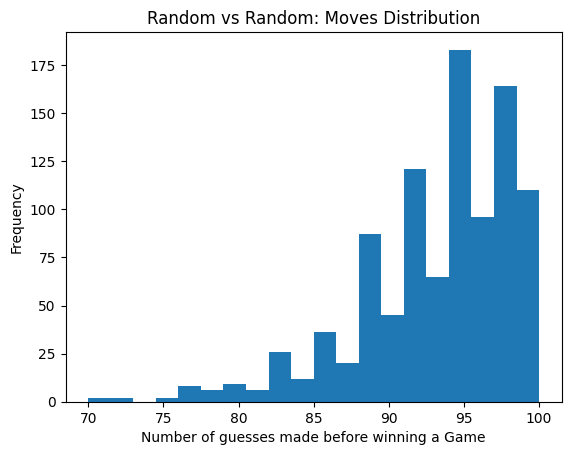

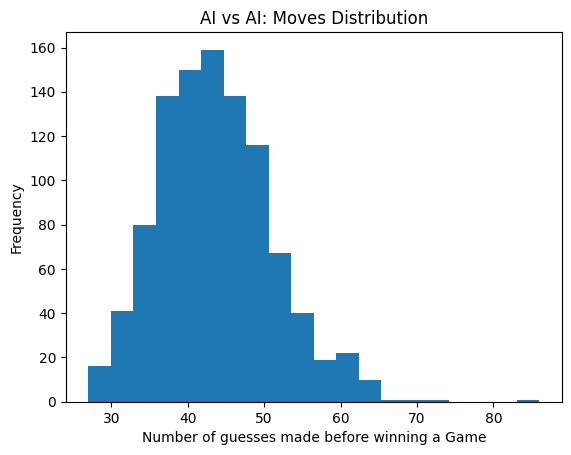

In [ ]:
import random
import statistics
import pandas as pd
import matplotlib.pyplot as plt

# --- Simulation parameters ---
BOARD_SIZE = 10
SHIP_SIZES = [5, 4, 3, 3, 2]

# --- Utility functions ---
def create_board():
    return [['~' for _ in range(BOARD_SIZE)] for _ in range(BOARD_SIZE)]

def is_game_over(ships):
    return len(ships) == 0

# --- Random placement & play ---
def generate_random_ships():
    board = create_board()
    ships = []
    for size in SHIP_SIZES:
        placed = False
        while not placed:
            dir = random.choice(['H','V'])
            if dir == 'H':
                r = random.randint(0, BOARD_SIZE-1)
                c = random.randint(0, BOARD_SIZE-size)
                coords = [(r, c+i) for i in range(size)]
            else:
                r = random.randint(0, BOARD_SIZE-size)
                c = random.randint(0, BOARD_SIZE-1)
                coords = [(r+i, c) for i in range(size)]
            if all(board[x][y] == '~' for x,y in coords):
                for x,y in coords:
                    board[x][y] = 'S'
                ships.append({'cells': coords.copy(), 'original': coords.copy()})
                placed = True
    return board, ships

def apply_shot(true_board, shots_board, ships, x, y):
    if true_board[x][y] == 'S':
        shots_board[x][y] = 'H'
        for i, ship in enumerate(ships):
            if (x,y) in ship['cells']:
                ship['cells'].remove((x,y))
                if not ship['cells']:
                    # mark sunk ship on shots_board
                    for r,c in ship['original']:
                        shots_board[r][c] = 'S'
                    del ships[i]
                    return 'sunk'
                return 'hit'
    else:
        shots_board[x][y] = 'M'
        return 'miss'

def simulate_random_game():
    p1_board, p1_ships = generate_random_ships()
    p2_board, p2_ships = generate_random_ships()
    p1_shots = create_board()
    p2_shots = create_board()
    p1_moves = p2_moves = 0

    while True:
        # Player 1 move
        x,y = random.randint(0,9), random.randint(0,9)
        while p1_shots[x][y] != '~':
            x,y = random.randint(0,9), random.randint(0,9)
        apply_shot(p2_board, p1_shots, p2_ships, x, y)
        p1_moves += 1
        if is_game_over(p2_ships):
            return 'P1', max(p1_moves, p2_moves)

        # Player 2 move
        x,y = random.randint(0,9), random.randint(0,9)
        while p2_shots[x][y] != '~':
            x,y = random.randint(0,9), random.randint(0,9)
        apply_shot(p1_board, p2_shots, p1_ships, x, y)
        p2_moves += 1
        if is_game_over(p1_ships):
            return 'P2', max(p1_moves, p2_moves)

# --- CSP‑based placement & AI targeting (your code) ---
def get_all_valid_placements(board, size):
    placements = []
    for r in range(BOARD_SIZE):
        for c in range(BOARD_SIZE-size+1):
            horiz = [(r, c+i) for i in range(size)]
            if all(board[r][c+i] == '~' for i in range(size)):
                placements.append(horiz)
    for r in range(BOARD_SIZE-size+1):
        for c in range(BOARD_SIZE):
            vert = [(r+i, c) for i in range(size)]
            if all(board[r+i][c] == '~' for i in range(size)):
                placements.append(vert)
    return placements

def place_ship_csp(board, size):
    choice = random.choice(get_all_valid_placements(board, size))
    for r,c in choice:
        board[r][c] = 'S'
    return choice

def place_all_ships_csp(board):
    ships = []
    for size in SHIP_SIZES:
        coords = place_ship_csp(board, size)
        ships.append({'cells': coords.copy(), 'original': coords.copy()})
    return ships

def get_connected_hits(shots_board, start):
    visited, to_visit, connected = set(), [start], []
    while to_visit:
        cell = to_visit.pop()
        if cell in visited: continue
        visited.add(cell)
        r,c = cell
        if shots_board[r][c] == 'H':
            connected.append(cell)
            for dr,dc in [(0,1),(1,0),(0,-1),(-1,0)]:
                nr,nc = r+dr, c+dc
                if 0<=nr<BOARD_SIZE and 0<=nc<BOARD_SIZE:
                    to_visit.append((nr,nc))
    return connected

def get_remaining_ship_sizes(ships):
    return [len(s['cells']) for s in ships]

def adjacent_non_diagonal(shots_board, cell):
    r,c = cell
    cand = []
    for dr,dc in [(0,1),(1,0),(0,-1),(-1,0)]:
        nr,nc = r+dr, c+dc
        if 0<=nr<BOARD_SIZE and 0<=nc<BOARD_SIZE and shots_board[nr][nc]=='~':
            cand.append((nr,nc))
    return cand

def generate_valid_placements_including_hit(board, size, hit):
    placements = []
    for r in range(BOARD_SIZE):
        for c in range(BOARD_SIZE-size+1):
            horiz = [(r, c+i) for i in range(size)]
            if hit in horiz and all(board[r][c+i] in ('~','H') for i in range(size)):
                placements.append(horiz)
    for r in range(BOARD_SIZE-size+1):
        for c in range(BOARD_SIZE):
            vert = [(r+i, c) for i in range(size)]
            if hit in vert and all(board[r+i][c] in ('~','H') for i in range(size)):
                placements.append(vert)
    return placements

def best_csp_target_move(shots_board, hit, remaining_sizes):
    targets = set()
    for size in remaining_sizes:
        for placement in generate_valid_placements_including_hit(shots_board, size, hit):
            for cell in placement:
                if shots_board[cell[0]][cell[1]] == '~':
                    targets.add(cell)
    if not targets: return None
    return max(targets, key=lambda cell: -((cell[0]-hit[0])*2 + (cell[1]-hit[1])*2))

def best_general_csp_move(shots_board, remaining_sizes):
    weights = [[0]*BOARD_SIZE for _ in range(BOARD_SIZE)]
    for size in remaining_sizes:
        for placement in get_all_valid_placements(shots_board, size):
            for r,c in placement:
                weights[r][c] += 1
    candidates = [(r,c) for r in range(BOARD_SIZE) for c in range(BOARD_SIZE)
                  if shots_board[r][c]=='~' and weights[r][c]>0]
    if not candidates: return None
    return max(candidates, key=lambda cell: weights[cell[0]][cell[1]])

def extended_target_move(shots_board, connected):
    # try line extension
    if len({r for r,_ in connected}) == 1:
        row = connected[0][0]
        cols = [c for _,c in connected]
        if min(cols)-1>=0 and shots_board[row][min(cols)-1]=='~':
            return (row, min(cols)-1)
        if max(cols)+1<BOARD_SIZE and shots_board[row][max(cols)+1]=='~':
            return (row, max(cols)+1)
    if len({c for _,c in connected}) == 1:
        col = connected[0][1]
        rows = [r for r,_ in connected]
        if min(rows)-1>=0 and shots_board[min(rows)-1][col]=='~':
            return (min(rows)-1, col)
        if max(rows)+1<BOARD_SIZE and shots_board[max(rows)+1][col]=='~':
            return (max(rows)+1, col)
    # otherwise centroid fallback
    cands = set()
    for cell in connected:
        cands.update(adjacent_non_diagonal(shots_board, cell))
    if not cands: return None
    cr = sum(r for r,_ in connected)/len(connected)
    cc = sum(c for _,c in connected)/len(connected)
    return min(cands, key=lambda cell: abs(cell[0]-cr)+abs(cell[1]-cc))

def ai_move(true_board, shots_board, ships, last_hit):
    if last_hit:
        conn = get_connected_hits(shots_board, last_hit)
        if conn:
            if len(conn)==1:
                adj = adjacent_non_diagonal(shots_board, last_hit)
                if adj: return random.choice(adj)
            ext = extended_target_move(shots_board, conn)
            if ext: return ext
        tgt = best_csp_target_move(shots_board, last_hit, get_remaining_ship_sizes(ships))
        if tgt: return tgt
    return best_general_csp_move(shots_board, get_remaining_ship_sizes(ships))

def simulate_ai_game():
    p1_board = create_board()
    p2_board = create_board()
    p1_ships = place_all_ships_csp(p1_board)
    p2_ships = place_all_ships_csp(p2_board)
    p1_shots = create_board()
    p2_shots = create_board()
    p1_moves = p2_moves = 0
    ai_hit = None
    opp_hit = None

    while True:
        # AI P1
        move = ai_move(p2_board, p1_shots, p2_ships, ai_hit)
        if move is None:
            # fallback random
            choices = [(r,c) for r in range(BOARD_SIZE) for c in range(BOARD_SIZE)
                       if p1_shots[r][c]=='~']
            move = random.choice(choices)
        x,y = move
        res = apply_shot(p2_board, p1_shots, p2_ships, x, y)
        p1_moves += 1
        if res=='hit':
            ai_hit = (x,y)
        elif res=='sunk':
            ai_hit = None
        if is_game_over(p2_ships):
            return 'P1',max(p1_moves, p2_moves)

        # AI P2
        move = ai_move(p1_board, p2_shots, p1_ships, opp_hit)
        if move is None:
            choices = [(r,c) for r in range(BOARD_SIZE) for c in range(BOARD_SIZE)
                       if p2_shots[r][c]=='~']
            move = random.choice(choices)
        x,y = move
        res = apply_shot(p1_board, p2_shots, p1_ships, x, y)
        p2_moves += 1
        if res=='hit':
            opp_hit = (x,y)
        elif res=='sunk':
            opp_hit = None
        if is_game_over(p1_ships):
            return 'P2', max(p1_moves, p2_moves)

# --- Run & plot ---
def simulate(n=1000):
    stats = {
        'random': {'P1':0,'P2':0,'moves':[]},
        'ai':     {'P1':0,'P2':0,'moves':[]}
    }
    for _ in range(n):
        w,m = simulate_random_game()
        stats['random'][w] += 1
        stats['random']['moves'].append(m)
    for _ in range(n):
        w,m = simulate_ai_game()
        stats['ai'][w] += 1
        stats['ai']['moves'].append(m)

    # summary table
    df = pd.DataFrame([
        ['Random vs Random',
         stats['random']['P1'], stats['random']['P2'],
         statistics.mean(stats['random']['moves']),
         statistics.median(stats['random']['moves'])],
        ['AI vs AI',
         stats['ai']['P1'], stats['ai']['P2'],
         statistics.mean(stats['ai']['moves']),
         statistics.median(stats['ai']['moves'])]
    ], columns=['Mode','P1 Wins','P2 Wins','Avg Moves','Median Moves'])
    print(df, "\n")

    # histogram Random vs Random
    plt.figure()
    plt.hist(stats['random']['moves'], bins=20)
    plt.title("Random vs Random: Moves Distribution")
    plt.xlabel("Number of guesses made before winning a Game")
    plt.ylabel("Frequency")
    plt.show()

    # histogram AI vs AI
    plt.figure()
    plt.hist(stats['ai']['moves'], bins=20)
    plt.title("AI vs AI: Moves Distribution")
    plt.xlabel("Number of guesses made before winning a Game")
    plt.ylabel("Frequency")
    plt.show()

if __name__ == '__main__':
    simulate(1000)